# Topic Modeling & Clustering of Interview Transcripts

In this notebook, we conducted a comprehensive topic modeling workflow on a set of interview transcripts using **BERTopic**. We began by loading the data, which included cleaned DOCX transcripts and accompanying participant metadata from an Excel file. During preprocessing, we removed speaker labels, timestamps, digits, and other irrelevant characters to clean the textual content. The interviews were then **chunked into smaller segments** to improve model granularity and coherence.

Each text chunk was **embedded using a SentenceTransformer**, clustered using **HDBSCAN**, and organized into **interpretable topics via BERTopic**. We visualized the initial output using bar charts and topic maps, giving a high-level overview of recurring themes in the data. The BERTopic model produced **386 unique topics**, excluding outliers labeled as topic `-1` (which represent noise and should not be interpreted substantively).

Since BERTopic only provides keywords and representative documents for each topic, we used an **LLM (Ollama’s `llama3:70b`)** to generate meaningful descriptions. The prompt instructed the model to behave like a qualitative researcher, summarizing each topic based on its keywords and representative text excerpts. These results are compiled in **`bert_topic_info.xlsx`**, with each row containing a topic, keywords, and a human-readable LLM-generated description (see the `description` column).

To explore the relationships between topics more deeply, we applied **hierarchical clustering** to the topic embeddings. Using **Ward linkage on cosine distances**, we grouped the topics into **30 broader clusters or "super-topics"**. Each cluster was labeled using its most prominent keywords, and we displayed example excerpts to contextualize the themes.

To enrich interpretation, we again used the **LLM to describe each cluster substantively**. These cluster-level summaries are stored in **`bertopic_cluster_description_llm.xlsx`** and are also shown in the notebook. Finally, we visualized the hierarchical structure of these clusters using a **dendrogram**, making it easier to understand how themes interrelate across the interview corpus.


In [5]:
# === Imports ===
import os
import re
import pandas as pd
from docx import Document
from collections import defaultdict
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.io as pio

/home/akroon/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:

pio.renderers.default = "notebook"  # Render in notebook cells

# === Paths ===
docx_dir = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/cleaned_interviews"
excel_file = "~/webdav/ASCOR-FMG-Microworkers (Projectfolder)/GW_interviews_participantlist.xlsx"

# === Load Metadata ===
df_meta = pd.read_excel(excel_file)

# === Load and Read DOCX Interviews ===
def read_docx_text(filepath):
    doc = Document(filepath)
    return "\n".join(para.text for para in doc.paragraphs)

doc_texts = {
    filename.replace(".docx", ""): read_docx_text(os.path.join(docx_dir, filename))
    for filename in tqdm(os.listdir(docx_dir), desc="Reading DOCX files")
    if filename.endswith(".docx")
}

df_meta["Interview_Text"] = df_meta["ID"].map(doc_texts)
df_combined = df_meta.dropna(subset=["Interview_Text"])

Reading DOCX files: 100%|██████████| 137/137 [10:32<00:00,  4.61s/it]


In [17]:
import csv

# Convert the dictionary to a DataFrame first
df_interviews = pd.DataFrame(list(doc_texts.items()), columns=["ID", "Interview_Text"])

# Save to CSV in the same directory as the Excel file
output_csv_path = os.path.expanduser(excel_file).replace(".xlsx", "_all_interviews.csv")
df_interviews.to_csv(output_csv_path, index=False)



In [2]:
import pandas as pd

# Define path
csv_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/GW_interviews_participantlist_all_interviews.csv"

# Read CSV
df_combined = pd.read_csv(csv_path)

# Quick check
print(f"✅ Loaded {len(df_combined)} combined interviews.")
print(df_combined.columns)
df_combined.head()


✅ Loaded 136 combined interviews.
Index(['ID', 'Interview_Text'], dtype='object')


ID                                     Interview_Text
0  AT01  INT1: 00:35\nOkay. Well, cool. Well, then I wi...
1  AT02  INT1: 00:32\n And if you don't mind, just tell...
2  AT03  INT1: 00:02\nAnd... Okay. So it's good to go. ...
3  BL01  \nINT1: 01:33\nOkay, cool. So if we can I'll g...
4  BL02  INT1: 00:04\n So then to start off, can you pl...

In [6]:
import re
# === Preprocessing: Cleaning ===
def clean_transcript(text):
    text = re.sub(r"\b[A-Z]{2,}\d*:", "", text)               # speaker labels
    text = re.sub(r"\b\d{1,2}:\d{2}(?::\d{2})?\b", "", text)   # timestamps
    text = re.sub(r"\b\w*\d\w*\b", "", text)                  # words with digits
    text = re.sub(r"\b\d{1,2}\b", "", text)                   # short numbers
    text = re.sub(r"[^a-zA-Z\s]", " ", text)                  # non-letters
    text = re.sub(r"\s+", " ", text)                          # normalize spaces
    text = re.sub(r"\b[a-hj-zA-Z]\b", "", text)               # remove 1-letter words
    return text.strip().lower()

texts = df_combined["Interview_Text"].map(clean_transcript).tolist()

# === Chunking ===
def chunk_text(doc, max_words=300):
    words = doc.split()
    return [" ".join(words[i:i + max_words]) for i in range(0, len(words), max_words)]

def chunk_all_texts(texts, max_words=300):
    chunked_docs, doc_ids = [], []
    for i, doc in enumerate(texts):
        chunks = chunk_text(doc, max_words=max_words)
        chunked_docs.extend(chunks)
        doc_ids.extend([i] * len(chunks))
    return chunked_docs, doc_ids

chunked_docs, doc_ids = chunk_all_texts(texts, max_words=300)

# === BERTopic Model Setup ===
vectorizer_model = CountVectorizer(
    stop_words="english", ngram_range=(1, 2), min_df=2, max_df=0.8
)
hdbscan_model = HDBSCAN(min_cluster_size=3, min_samples=1, prediction_data=True)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    calculate_probabilities=True,
    verbose=True
)

# === Fit the Model ===
topics, probs = topic_model.fit_transform(chunked_docs)

# === Visualize Top Topics ===
fig_bar = topic_model.visualize_barchart(top_n_topics=10)
fig_bar.show()

fig_clusters = topic_model.visualize_topics()
fig_clusters.show()

2025-07-07 20:35:05,018 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 88/88 [00:02<00:00, 31.35it/s]
2025-07-07 20:35:08,004 - BERTopic - Embedding - Completed ✓
2025-07-07 20:35:08,004 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-07 20:35:21,985 - BERTopic - Dimensionality - Completed ✓
2025-07-07 20:35:21,986 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-07 20:35:40,525 - BERTopic - Cluster - Completed ✓
2025-07-07 20:35:40,529 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-07 20:35:41,344 - BERTopic - Representation - Completed ✓


In [9]:
len(topic_model.get_topics())


386

In [10]:
# === Topic Description with LLM (Ollama) ===
import subprocess
import pandas as pd
from tqdm import tqdm

LLM_MODEL_NAME = "llama3:70b"  # Or use "llama3:70b" if available and fast enough

def query_ollama(prompt, model=LLM_MODEL_NAME):
    """Run prompt through Ollama CLI and return the output."""
    try:
        result = subprocess.run(
            ["ollama", "run", model],
            input=prompt.encode("utf-8"),
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True,
            timeout=60
        )
        return result.stdout.decode("utf-8").strip()
    except subprocess.CalledProcessError as e:
        print(f"[ERROR] Ollama failed:\n{e.stderr.decode('utf-8')}")
        return "Error"
    except subprocess.TimeoutExpired:
        print("[TIMEOUT] Ollama timed out.")
        return "Timeout"

def describe_topics(topic_model):
    topic_info = topic_model.get_topic_info()
    topics_to_describe = topic_info[topic_info.Topic != -1]
    topic_descriptions = []

    for topic_id in tqdm(topics_to_describe.Topic, desc="Describing topics"):
        words = [w for w, _ in topic_model.get_topic(topic_id)[:10]]
        docs = topic_model.get_representative_docs(topic_id)[:2]

        prompt = f"""
You are an expert in qualitative research. Your task is to describe a topic based on its keywords and example text.

Topic ID: {topic_id}
Top Keywords: {', '.join(words)}

Example excerpts:
1. {docs[0]}
2. {docs[1]}

Please provide a short descriptive summary of what this topic is about.
"""
        response = query_ollama(prompt)
        topic_descriptions.append({
            "topic_id": topic_id,
            "keywords": ", ".join(words),
            "description": response
        })

        output_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_descriptions_with_llm.csv"
        df_descriptions = pd.DataFrame(topic_descriptions)  # 
        df_descriptions.to_csv(output_path, index=False)

# === Call the description function ===
describe_topics(topic_model)

Describing topics: 100%|██████████| 385/385 [2:35:54<00:00, 24.30s/it]  


In [ ]:
### Merge topic df with the LLM labels 

In [11]:
desc_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_descriptions_with_llm.csv"
df_desc = pd.read_csv(desc_path)

In [12]:
df_desc

topic_id                                           keywords  \
0           0  amazon, hits, turk, scripts, script, amazon tu...   
1           1  uber, regulation, eu, criteria, directive, pla...   
2           2  morning, day, week, evening, hours, routine, d...   
3           3  family, family business, child, children, husb...   
4           4  term, hours know, hours, ones, long term, task...   
..        ...                                                ...   
380       380  occasional, complicated, taxation, considered ...   
381       381  crowds, research team, phd student, think work...   
382       382  hitapps, banned, let log, got banned, profile,...   
383       383  level, hasn, getting new, corner, scores, cert...   
384       384  hospitality, inconveniences, sectors, designin...   

                                           description  
0    Based on the provided keywords and example tex...  
1    Based on the keywords and example text, this t...  
2    Based on the keywords and example excerpts, I ...  
3    Based on the provided keywords and example tex...  
4    Based on the keywords and example excerpts, th...  
..                                                 ...  
380  Based on the provided keywords and example exc...  
381  Based on the provided keywords and example tex...  
382  Based on the provided keywords and example tex...  
383  Based on the provided keywords and example tex...  
384  Based on the keywords and example excerpts, I ...  

[385 rows x 3 columns]

In [13]:
topic_info = topic_model.get_topic_info()
topic_info = topic_info.merge(df_desc, left_on="Topic", right_on="topic_id", how="left")

In [15]:
# Define paths
base_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output"
csv_path = os.path.join(base_path, "bertopic_topic_info.csv")
excel_path = os.path.join(base_path, "bertopic_topic_info.xlsx")

# Save to CSV
topic_info.to_csv(csv_path, index=False)

# Save to Excel
topic_info.to_excel(excel_path, index=False)

print(f"✅ Saved topic info to:\n- {csv_path}\n- {excel_path}")

✅ Saved topic info to:
- /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_topic_info.csv
- /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_topic_info.xlsx


In [27]:
custom_labels = {
    row["Topic"]: f"Topic {row['Topic']}: {row['description'][:100]}..."  # short preview
    for _, row in topic_info.iterrows()
    if row["Topic"] != -1 and pd.notnull(row["description"])
}
topic_model.set_topic_labels(custom_labels)

In [28]:
fig = topic_model.visualize_topics()
html_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_topics_with_descriptions.html"
fig.write_html(html_path)
print(f"✅ Saved interactive topic visualization to {html_path}")

✅ Saved interactive topic visualization to /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_topics_with_descriptions.html


In [39]:
import pandas as pd

# Paths
html_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_barchart_with_all_descriptions.html"
desc_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_topic_info.csv"

# Load LLM topic descriptions
df_desc = pd.read_csv(desc_path)
topic_id_to_desc = dict(zip(df_desc["Topic"], df_desc["description"]))

# Count number of valid topics (excluding noise -1)
valid_topics = [tid for tid in topic_model.get_topics().keys() if tid != -1]
num_valid_topics = len(valid_topics)

# Generate BERTopic bar chart figure for all valid topics
fig_bar = topic_model.visualize_barchart(top_n_topics=num_valid_topics)

# Export figure HTML snippet (without full html wrapper, to embed below)
html_chart = fig_bar.to_html(full_html=False, include_plotlyjs='cdn')

# Prepare description HTML, skipping noise topic (-1)
description_html = "<h2>Topic Descriptions</h2>\n"
for tid in sorted(topic_id_to_desc.keys()):
    if tid == -1:
        continue
    desc = topic_id_to_desc[tid]
    description_html += f"<h4>Topic {tid}</h4>\n<p>{desc}</p>\n"

# Combine into full HTML page
full_html = f"""
<html>
<head>
    <title>BERTopic Visualization of All Topics with LLM Descriptions</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; }}
        h2 {{ border-bottom: 2px solid #444; padding-bottom: 6px; }}
        h4 {{ margin-top: 20px; }}
        p {{ max-width: 800px; }}
    </style>
</head>
<body>
{html_chart}
<hr>
{description_html}
</body>
</html>
"""

# Write to file
with open(html_path, "w", encoding="utf-8") as f:
    f.write(full_html)

print(f"✅ Saved full bar chart + LLM descriptions for all topics to:\n{html_path}")


✅ Saved full bar chart + LLM descriptions for all topics to:
/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_barchart_with_all_descriptions.html


In [19]:
# === Count Topics ===
num_unique_topics = len(set(topics))  # includes -1 (outliers)
filtered_topics = [t for t in topics if t != -1]
num_valid_topics = len(set(filtered_topics))

# === Visualization and Save to HTML ===
fig_all = topic_model.visualize_barchart(top_n_topics=num_valid_topics)

# Define output path
output_html_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/all_discovered_topics_barchart.html"
fig_all.write_html(output_html_path)

print(f"✅ Saved full topic bar chart with {num_valid_topics} topics to:\n{output_html_path}")


✅ Saved full topic bar chart with 385 topics to:
/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/all_discovered_topics_barchart.html


In [20]:
topic_info_df = topic_model.get_topic_info()
topic_info_df.head()

Topic  Count                                     Name  \
0     -1    631            -1_money_mean_different_tasks   
1      0     37               0_amazon_hits_turk_scripts   
2      1     24            1_uber_regulation_eu_criteria   
3      2     23               2_morning_day_week_evening   
4      3     20  3_family_family business_child_children   

                                          CustomName  \
0                      -1_money_mean_different_tasks   
1  Topic 0: Based on the provided keywords and ex...   
2  Topic 1: Based on the keywords and example tex...   
3  Topic 2: Based on the keywords and example exc...   
4  Topic 3: Based on the provided keywords and ex...   

                                      Representation  \
0  [money, mean, different, tasks, didn, did, bet...   
1  [amazon, hits, turk, scripts, script, amazon t...   
2  [uber, regulation, eu, criteria, directive, pl...   
3  [morning, day, week, evening, hours, routine, ...   
4  [family, family business, child, children, hus...   

                                 Representative_Docs  
0  [colleagues mean can you help me in this one w...  
1  [any kind of tool like told you with the softw...  
2  [as taxi driver would paid for driving taxi li...  
3  [whole family it was really nice cool we also ...  
4  [this helps me to do this crowdwork because go...

In [21]:
len(topic_info)

386

In [24]:
from tqdm import tqdm
import pandas as pd
import os

def describe_clusters_with_llm(cluster_to_docs, cluster_names, output_dir, model_name="llama3:70b"):
    cluster_descriptions = []

    print("🧠 Generating LLM-based descriptions for topic clusters...")

    for cid in tqdm(sorted(cluster_to_docs), desc="Describing clusters"):
        example_docs = cluster_to_docs[cid][:2]
        keywords = cluster_names.get(cid, "N/A")

        if len(example_docs) < 2:
            example_docs += ["(No example)"] * (2 - len(example_docs))

        prompt = f"""
You are a qualitative researcher. Based on the following keywords and example excerpts, summarize what this topic cluster is about.

Cluster ID: {cid}
Top Keywords: {keywords}

Example excerpts:
1. {example_docs[0]}
2. {example_docs[1]}

Please provide a short descriptive summary of what this cluster is about.
"""
        response = query_ollama(prompt, model=model_name)

        cluster_descriptions.append({
            "cluster_id": cid,
            "keywords": keywords,
            "description": response
        })

    # === Save Results ===
    df_clusters = pd.DataFrame(cluster_descriptions)
    os.makedirs(output_dir, exist_ok=True)
    csv_path = os.path.join(output_dir, "bertopic_cluster_descriptions_llm.csv")
    excel_path = os.path.join(output_dir, "bertopic_cluster_descriptions_llm.xlsx")

    df_clusters.to_csv(csv_path, index=False)
    df_clusters.to_excel(excel_path, index=False)

    print(f"✅ Saved cluster descriptions to:\n📄 CSV:   {csv_path}\n📊 Excel: {excel_path}")
    return df_clusters

In [25]:
output_dir = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output"
df_clusters = describe_clusters_with_llm(cluster_to_docs, cluster_names, output_dir)

🧠 Generating LLM-based descriptions for topic clusters...


Describing clusters: 100%|██████████| 30/30 [11:16<00:00, 22.56s/it]


✅ Saved cluster descriptions to:
📄 CSV:   /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_cluster_descriptions_llm.csv
📊 Excel: /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_cluster_descriptions_llm.xlsx


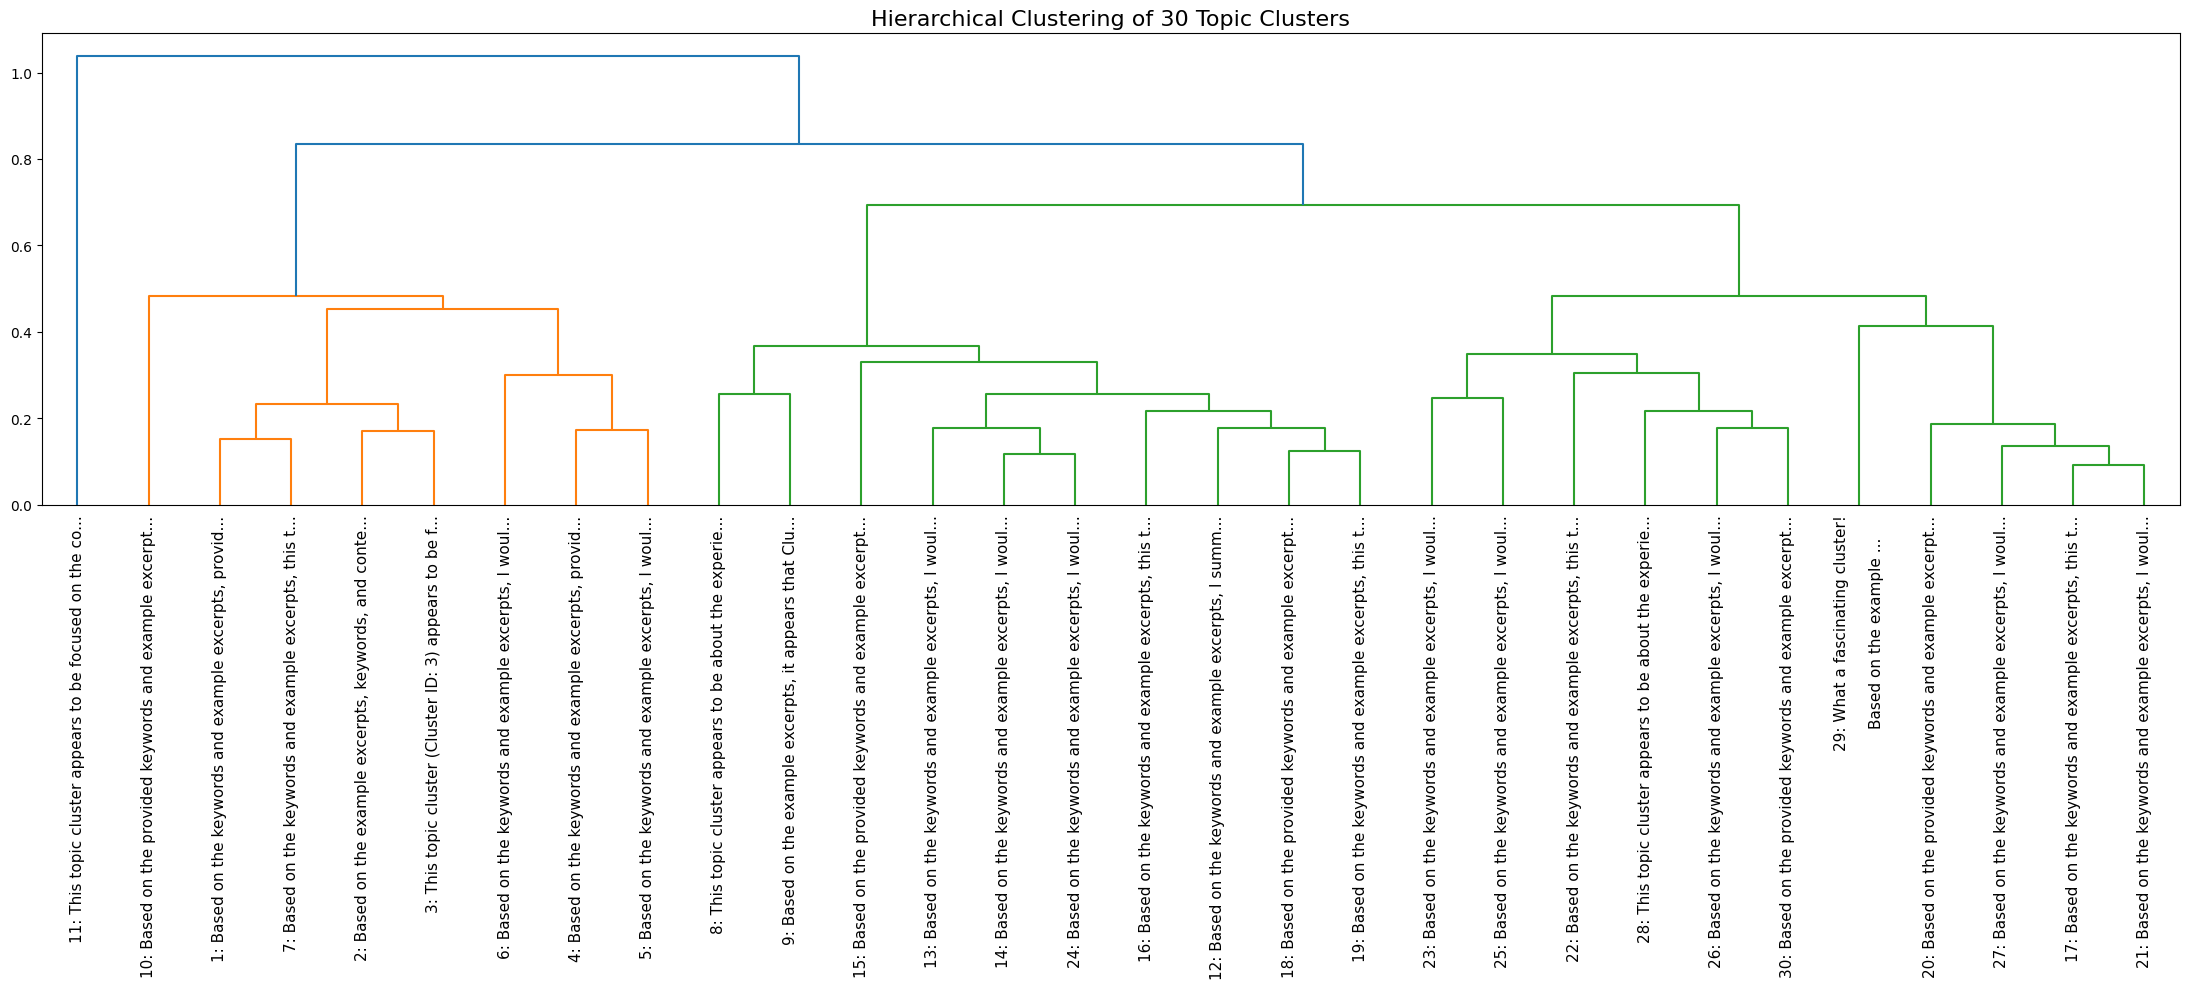


🧠 Cluster 1: Based on the keywords and example excerpts, provided, I would summarize Cluster ID: 1 as follows:

This topic cluster revolves around the theme of trust, control, and motivation in online crowdsourcing and microwork platforms. The discussions center around the importance of transparency, accountability, and fair compensation in these platforms, with participants expressing concerns about the lack of trustworthiness, minimalistic design, and opacity of some platforms. They also share their frustrations with low pay, rejection of work, and the need for better communication channels to ensure motivation and continued participation. The cluster explores the users' desire for a reliable and rewarding online work environment.
→ 74 documents
📄 Examples:
— they guarantee that nothing malicious is going to come from it maybe add little icon like you say this important is trustworthy and he has proven not to blah blah blah blah do whatever with your piece ...

— at microworkers use

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from collections import defaultdict
from tqdm import tqdm

# === Load cluster-level LLM descriptions ===
desc_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/bertopic_cluster_descriptions_llm.csv"
df_desc = pd.read_csv(desc_path)
cluster_id_to_desc = dict(zip(df_desc["cluster_id"], df_desc["description"]))

# === Step 1: Filter valid topic IDs and embeddings ===
valid_topic_ids = [tid for tid in topic_model.get_topics().keys() if tid != -1]
clustering_topic_id_to_index = {tid: i for i, tid in enumerate(valid_topic_ids)}
embedding_indices = [clustering_topic_id_to_index[tid] for tid in valid_topic_ids]
filtered_embeddings = topic_model.topic_embeddings_[embedding_indices]

# === Step 2: Compute pairwise distances and linkage ===
distance_matrix = pdist(filtered_embeddings, metric="cosine")
linkage_matrix = linkage(distance_matrix, method="ward")

# === Step 3: Choose number of clusters and assign each topic to a cluster ===
n_clusters = 30
cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion="maxclust")

# === Step 4: Map topics to clusters ===
cluster_to_topic_ids = defaultdict(list)
for tid, cid in zip(valid_topic_ids, cluster_labels):
    cluster_to_topic_ids[cid].append(tid)

# === Step 5: Derive fallback keywords per cluster ===
cluster_names = {}
for cid, tids in cluster_to_topic_ids.items():
    top_words = []
    for tid in tids[:5]:  # sample 5 topics
        words = topic_model.get_topic(tid)
        if words:
            top_words.extend([w for w, _ in words[:2]])  # top 2 words
    label = ", ".join(sorted(set(top_words)))[:40] + "..."
    cluster_names[cid] = label

# === Step 6: Prepare dendrogram labels (LLM description or fallback) ===
cluster_embeddings = []
cluster_labels_readable = []

for cid in sorted(cluster_to_topic_ids):
    tids = cluster_to_topic_ids[cid]
    indices = [clustering_topic_id_to_index[tid] for tid in tids]
    emb = np.mean(filtered_embeddings[indices], axis=0)
    cluster_embeddings.append(emb)

    desc = cluster_id_to_desc.get(cid, cluster_names[cid])
    label = f"{cid}: {desc[:50]}..."
    cluster_labels_readable.append(label)

# === Step 7: Dendrogram ===
cluster_distance = pdist(np.array(cluster_embeddings), metric="cosine")
cluster_linkage = linkage(cluster_distance, method="ward")

plt.figure(figsize=(22, 10))
dendrogram(
    cluster_linkage,
    labels=cluster_labels_readable,
    leaf_rotation=90,
    leaf_font_size=11,
)
plt.title(f"Hierarchical Clustering of {n_clusters} Topic Clusters", fontsize=16)
plt.tight_layout()
plt.show()

# === Step 8: Map each chunk to a cluster for review ===
topic_to_cluster = {
    tid: cluster_labels[clustering_topic_id_to_index[tid]] for tid in valid_topic_ids
}

cluster_to_docs = defaultdict(list)
for doc, topic in zip(chunked_docs, topics):
    if topic == -1 or topic not in topic_to_cluster:
        continue
    cluster_id = topic_to_cluster[topic]
    cluster_to_docs[cluster_id].append(doc)

# === Step 9: Print cluster summaries with examples ===
for cid in sorted(cluster_to_docs):
    desc = cluster_id_to_desc.get(cid, cluster_names[cid])
    print(f"\n🧠 Cluster {cid}: {desc}")
    print(f"→ {len(cluster_to_docs[cid])} documents")
    print("📄 Examples:")
    for example in cluster_to_docs[cid][:3]:  # show first 3
        print("—", example[:200].strip(), "...\n")

# === Step 10: Optional: Save cluster descriptions again (as backup) ===
df_desc.to_csv(desc_path, index=False)
df_desc.to_excel(desc_path.replace(".csv", ".xlsx"), index=False)
print(f"\n✅ Cluster descriptions saved to:\n{desc_path}")


In [40]:
import io
import base64
import matplotlib.pyplot as plt

# === Generate and encode dendrogram image ===
fig, ax = plt.subplots(figsize=(22, 10))
dendrogram(
    cluster_linkage,
    labels=cluster_labels_readable,
    leaf_rotation=90,
    leaf_font_size=11,
    ax=ax
)
plt.title(f"Hierarchical Clustering of {n_clusters} Topic Clusters", fontsize=16)
plt.tight_layout()

buf = io.BytesIO()
plt.savefig(buf, format="png")
plt.close(fig)
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
buf.close()

# === Generate HTML body ===
html_parts = [
    "<html><head><meta charset='utf-8'>",
    "<style>body { font-family: Arial; padding: 2em; } h2 { color: #333; } .cluster { margin-bottom: 2em; } pre { background: #f4f4f4; padding: 1em; } </style>",
    "</head><body>",
    f"<h1>Hierarchical Clustering of {n_clusters} Topic Clusters</h1>",
    "<h2>Dendrogram</h2>",
    f"<img src='data:image/png;base64,{img_base64}' style='width:100%; max-width:1400px;'/>",
    "<h2>Cluster Summaries</h2>"
]

for cid in sorted(cluster_to_docs):
    desc = cluster_id_to_desc.get(cid, cluster_names[cid])
    html_parts.append(f"<div class='cluster'><h3>🧠 Cluster {cid}: {desc}</h3>")
    html_parts.append(f"<p><strong>→ {len(cluster_to_docs[cid])} documents</strong></p>")
    html_parts.append("<h4>📄 Examples:</h4><ul>")
    for example in cluster_to_docs[cid][:3]:
        snippet = example[:200].strip().replace("<", "&lt;").replace(">", "&gt;")
        html_parts.append(f"<li><pre>{snippet}...</pre></li>")
    html_parts.append("</ul></div>")

html_parts.append("</body></html>")

# === Save to HTML file ===
output_path = "/home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/cluster_report.html"
with open(output_path, "w", encoding="utf-8") as f:
    f.write("\n".join(html_parts))

print(f"\n✅ Report saved to: {output_path}")



✅ Report saved to: /home/akroon/webdav/ASCOR-FMG-Microworkers (Projectfolder)/output/cluster_report.html
